In [1]:
# General Imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Sklearn packages
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.feature_selection import RFE

from sklearn.model_selection import StratifiedKFold

# embedded methods
from sklearn.linear_model import LassoCV
import scipy.stats as stats
from scipy.stats import chi2_contingency

from sklearn.preprocessing import LabelEncoder

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

from sklearn.metrics import classification_report, f1_score

from util_train import *
from utils import *
import xgboost as xgb

import warnings
warnings.filterwarnings("ignore")

%load_ext autoreload
%autoreload 2

In [2]:
reference_date = pd.to_datetime("2023-01-01")

In [3]:
train_df = pd.read_csv("./data/train_data_after_EDA.csv", index_col="Claim Identifier")

In [4]:
numerical_features = [
    "Age at Injury",
    "WCIO Cause of Injury Code",
    "WCIO Nature of Injury Code",
    "WCIO Part Of Body Code",
    "Number of Dependents",
    "Years Past Accident",
    "Assembly Years past Accident",
    "Industry Code",
    "Birth Year",
    "Average Weekly Wage",
    "IME-4 Count"
]

categorical_features = [
    "Carrier Name",
    "Carrier Type",
    "County of Injury",
    "District Name",
    "Gender",
    "Medical Fee Region",
    "Zip Code"
]

binary_features = [
    "Alternative Dispute Resolution",
    "Attorney/Representative",
    "COVID-19 Indicator",
    "First Hearing Date Occurred",
    "C-2 Date Occurred",
    "C-3 Date Occurred"
]


In [5]:
for col in numerical_features+categorical_features+binary_features:
    if col not in train_df.columns:
        print(col)
print("-------")
for col in train_df.columns:
    if col not in numerical_features+categorical_features+binary_features:
        print(col)

-------
Accident Date
Claim Injury Type


In [6]:
train_df.dropna(subset = ["Accident Date", "Age at Injury","Birth Year","Years Past Accident","Assembly Years past Accident"], inplace=True)

In [7]:
X = train_df.drop(["Claim Injury Type"], axis = 1)
y = train_df["Claim Injury Type"]

In [8]:
X_train_90, X_test, y_train_90, y_test = train_test_split(X,y, test_size = 0.1, random_state = 69, stratify = y, shuffle = True)

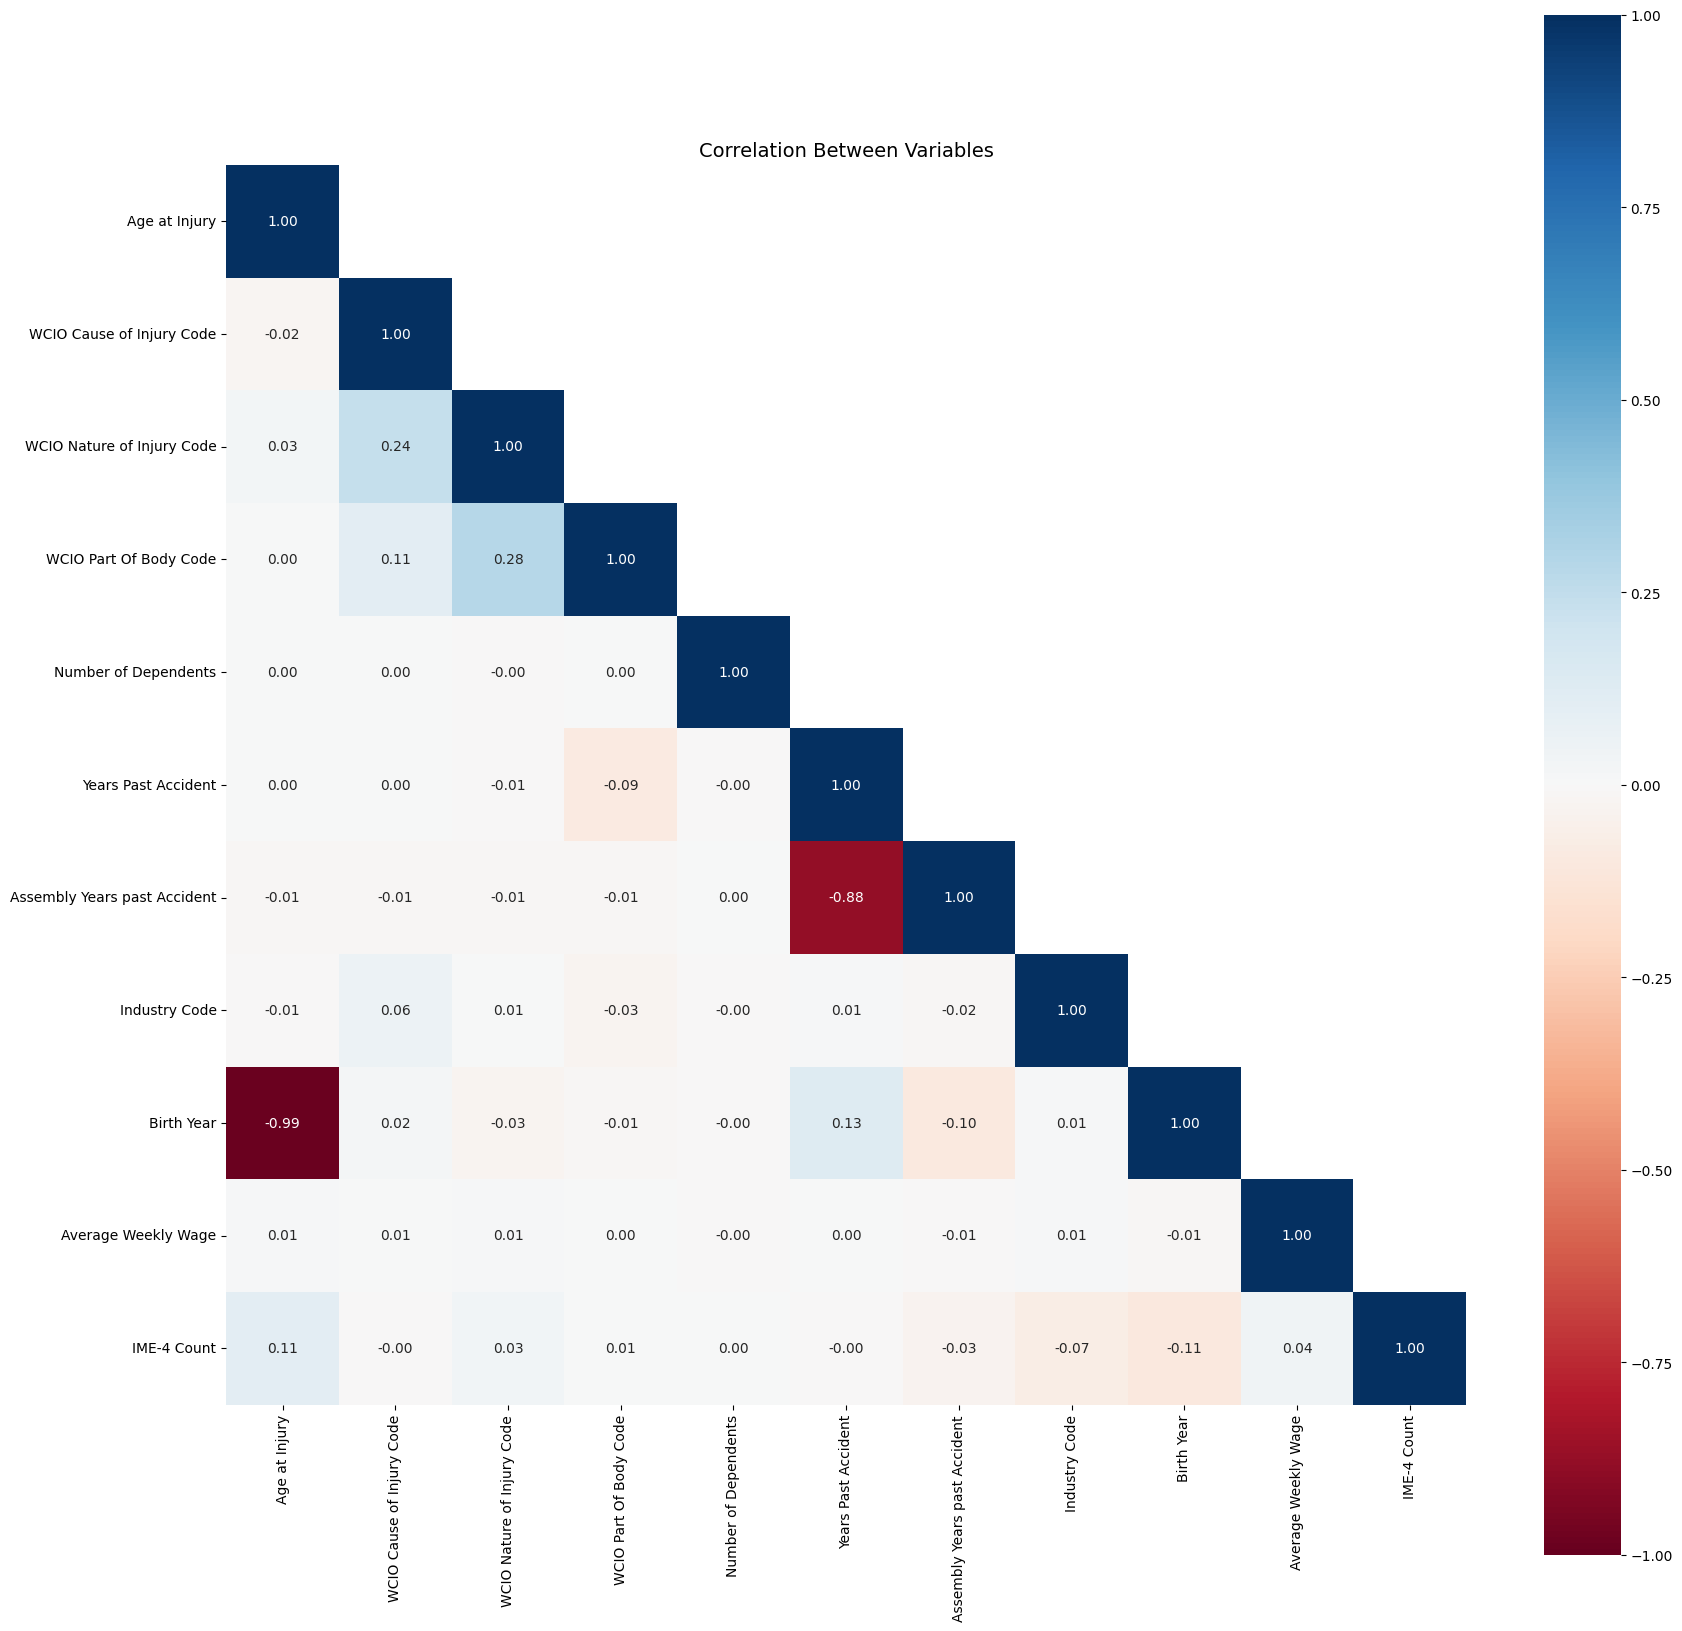

In [9]:
# initial correlation matrix with the respective values
corr_matrix = X_train_90[numerical_features].corr()

mask = np.tri(*corr_matrix.shape, k=0, dtype=bool)
# Keeps values where mask is True
corr_matrix = corr_matrix.where(mask)

# defines the figure size
fig, ax = plt.subplots(figsize=(20, 20))
# heatmap of the initial correlation matrix
l = sns.heatmap(corr_matrix, square=True, annot=True, fmt=".2f", vmax=1, vmin=-1, cmap='RdBu', ax=ax)
plt.title('Correlation Between Variables', size=14)
plt.show()

In [10]:
X_train_temp, X_val_temp, y_train_temp, y_val_temp = train_test_split(X_train_90,y_train_90, test_size = 0.25, random_state = 42, stratify = y_train_90, shuffle = True)

In [11]:
to_impute = ["Average Weekly Wage","Industry Code"]

In [12]:
to_impute = ["Average Weekly Wage","Industry Code"]
for feature_na in to_impute:
    imputer = KNNImputer(n_neighbors=3)
    X_train_temp[[feature_na]] = imputer.fit_transform(X_train_temp[[feature_na]])
    X_val_temp[[feature_na]] = imputer.transform(X_val_temp[[feature_na]])

In [13]:
feature_to_scale = numerical_features+categorical_features
mm = MinMaxScaler()
X_train_temp[feature_to_scale] = mm.fit_transform(X_train_temp[feature_to_scale])
X_val_temp[feature_to_scale] = mm.transform(X_val_temp[feature_to_scale])

In [14]:
RFE_XGB_best = feature_selection_RFE(X_train_temp[numerical_features],y_train_temp,n_features=len(numerical_features)
                                    ,model = xgb.XGBClassifier(
                                                    objective='binary:logistic',  
                                                    eval_metric='logloss',         
                                                    use_label_encoder=False,                 
                                                ))

In [15]:
RFE_DT_best = feature_selection_RFE(X_train_temp[numerical_features],y_train_temp,n_features=len(numerical_features)
                                    ,model = DecisionTreeClassifier(max_depth=5, min_samples_leaf=10, class_weight='balanced'))

In [16]:
RFE_XGB_best

['Age at Injury',
 'WCIO Cause of Injury Code',
 'WCIO Nature of Injury Code',
 'WCIO Part Of Body Code',
 'Years Past Accident',
 'Assembly Years past Accident',
 'Industry Code',
 'Birth Year',
 'Average Weekly Wage',
 'IME-4 Count']

In [17]:
RFE_DT_best

['WCIO Nature of Injury Code', 'Average Weekly Wage', 'IME-4 Count']

In [18]:
missing_percentage = X_train_temp.isna().sum() / len(X_train_temp) * 100
for col, percent in missing_percentage.items():
    if not percent == 0:
        print(f"{col}: {percent:.2f}% missing values")

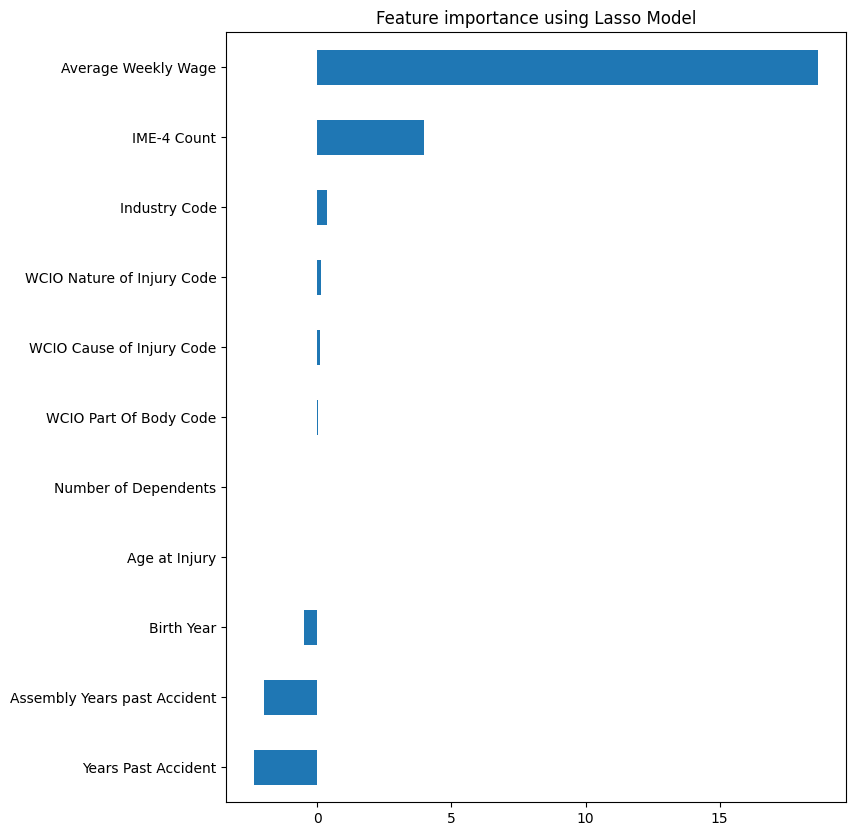

Age at Injury                    0.000000
WCIO Cause of Injury Code        0.088953
WCIO Nature of Injury Code       0.146421
WCIO Part Of Body Code           0.022541
Number of Dependents             0.000000
Years Past Accident             -2.351650
Assembly Years past Accident    -2.003176
Industry Code                    0.351363
Birth Year                      -0.518990
Average Weekly Wage             18.673098
IME-4 Count                      3.964885
dtype: float64


In [19]:
feature_selection_Lasso(X_train_temp[numerical_features],y_train_temp)

In [20]:
for col in categorical_features+binary_features:
    TestIndependence(X_train_temp[col],y,col,alpha=0.05)

Carrier Name is IMPORTANT for Prediction
Carrier Type is IMPORTANT for Prediction
County of Injury is IMPORTANT for Prediction
District Name is IMPORTANT for Prediction
Gender is IMPORTANT for Prediction
Medical Fee Region is IMPORTANT for Prediction
Zip Code is IMPORTANT for Prediction
Alternative Dispute Resolution is IMPORTANT for Prediction
Attorney/Representative is IMPORTANT for Prediction
COVID-19 Indicator is IMPORTANT for Prediction
First Hearing Date Occurred is IMPORTANT for Prediction
C-2 Date Occurred is IMPORTANT for Prediction
C-3 Date Occurred is IMPORTANT for Prediction


<hr>

### Numerical Data

| Predictor | Spearman | RFE LR| RFE DT | Lasso | What to do? (One possible way to "solve") |
| --- | --- | --- | --- |--- |---|
| Age at Injury | Keep? | Keep | Discard |Keep? | Try with and without |
| IME-4 Count | Keep | Keep | Keep |Keep| Include in the model |
| WCIO Cause of Injury Code | Keep?| Keep | Keep | Discard | Try with and without |
| WCIO Nature of Injury Code | Keep? | Keep | Keep | Discard | Try with and without |
| WCIO Part Of Body Code | Keep | Keep | Keep | Discard | Try with and without |
| Number of Dependents | Keep | Discard | Discard | Discard | Discard |
| Accident Days | Keep |Keep |Keep | Keep? |  Include in the model |
| Assembly Days | Keep |Keep |Discart | Keep? |  Try with and without |
| First Hearing Days | Keep |Keep |Keep | Keep |   Include in the model |
| Age | Keep |Discard |Discard | Keep? |  Discard |
| C-2 Days | Keep |Keep |Keep | Keep |  Include in the model |
| C-3 Days | Keep |Keep |Keep | Keep |  Include in the model |

<hr>


### Categorical Data

| Predictor | Chi-Square |
| --- | --- |
| Carrier Name | Keep |  
| Carrier Type | Keep |
| County of Injury| Keep|
| District Name| Keep|
| Gender | Keep |
| Medical Fee Region | Keep |
| Attorney/Representative | Keep |
| COVID-19 Indicator | Keep |
| First Hearing Date Occurred | Keep |
| C-2 Date Occurred | Keep |
| C-3 Date Occurred| Keep |
| Birth Year Occurred | Keep |
| Age at Injury Occurred | Keep |
| Accident Date Occurred | KEEP |

<hr>

In [21]:
# MAYBE DO KFOLD BEFORE THEM TRAIN MODELS

In [22]:
to_impute = ["Average Weekly Wage","Industry Code"]
for feature_na in to_impute:
    imputer = KNNImputer(n_neighbors=3)
    X_train_90[[feature_na]] = imputer.fit_transform(X_train_90[[feature_na]])
    X_train_90[[feature_na]] = imputer.transform(X_train_90[[feature_na]])

In [26]:
feature_to_scale = numerical_features
for feature in feature_to_scale:
    if feature not in RFE_XGB_best or feature not in categorical_features:
        feature_to_scale.remove(feature)
feature_to_scale += categorical_features

In [27]:
feature_to_use = RFE_XGB_best + categorical_features + binary_features

In [28]:
X_train_90 = X_train_90[feature_to_use]

In [30]:
n_folds = 5
K_fold = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)

models = []
scaler_means = []
scaler_vars = []
fold = 1

for train_index, val_index in K_fold.split(X_train_90, y_train_90):
    X_train, X_val = X_train_90.iloc[train_index], X_train_90.iloc[val_index]
    y_train, y_val = y_train_90.iloc[train_index], y_train_90.iloc[val_index]


    smote = SMOTE(random_state=42)
    X_train, y_train = smote.fit_resample(X_train, y_train)
    
        
    scaler = StandardScaler().fit(X_train[feature_to_scale])
    X_train[feature_to_scale]  = scaler.transform(X_train[feature_to_scale])
    X_val[feature_to_scale]  = scaler.transform(X_val[feature_to_scale])  
    
    scaler_means.append(scaler.mean_)
    scaler_vars.append(scaler.var_)

   # model = DecisionTreeClassifier(max_depth=5, min_samples_leaf=10, random_state=None)
    model= xgb.XGBClassifier(
                objective='binary:logistic',  
                eval_metric='logloss',        
                use_label_encoder=False,   
                device = "cuda",
                n_estimators=100,          
                max_depth=6,                 
                learning_rate=0.1,         
                subsample=0.8,               
                colsample_bytree=0.8,         
                random_state=42
            )
    model.fit(X_train, y_train)

    # Model that can find classes with very low data
    
    models.append(model)
    
    y_val_pred = model.predict(X_val)
    f1 = f1_score(y_val, y_val_pred, average='macro')
    print(f"Fold {fold} validation F1 score: {f1:.4f}")
    fold += 1


Fold 1 validation F1 score: 0.4248
Fold 2 validation F1 score: 0.4154
Fold 3 validation F1 score: 0.4247
Fold 4 validation F1 score: 0.4240
Fold 5 validation F1 score: 0.4237


In [31]:
class_mapping = {0: '1. CANCELLED', 1: '2. NON-COMP', 2: '3. MED ONLY', 3: '4. TEMPORARY', 4: '5. PPD SCH LOSS', 5: '6. PPD NSL', 6: '7. PTD', 7: '8. DEATH'}
test_encoder = LabelEncoder()
test_encoder.classes_ = np.array(list(class_mapping.values()))

In [32]:
X_test = X_test[feature_to_use]

In [34]:
final_scaler_mean = np.mean(scaler_means, axis=0)
final_scaler_var = np.mean(scaler_vars, axis=0)

final_scaler = StandardScaler()
final_scaler.mean_ = final_scaler_mean
final_scaler.scale_ = np.sqrt(final_scaler_var)

X_test[feature_to_scale] = final_scaler.transform(X_test[feature_to_scale])

pred_test_probs = np.zeros((X_test.shape[0], len(test_encoder.classes_)))  # criar um array para meter as probabilidades

for model in models:
    pred_test_prob = model.predict_proba(X_test) 
    pred_test_probs += pred_test_prob / n_folds 

pred_test = np.argmax(pred_test_probs, axis=1)

In [35]:
print(classification_report(y_test, pred_test))

              precision    recall  f1-score   support

           0       0.14      0.76      0.24      1074
           1       0.94      0.01      0.03     28803
           2       0.15      0.59      0.23      6862
           3       0.69      0.55      0.62     14791
           4       0.55      0.67      0.60      4826
           5       0.07      0.73      0.13       421
           6       0.01      0.20      0.01        10
           7       0.06      0.70      0.11        47

    accuracy                           0.30     56834
   macro avg       0.33      0.53      0.25     56834
weighted avg       0.72      0.30      0.26     56834



In [ ]:
# JOIN 2 MODELS

In [ ]:
# TRAIN MODELS

In [ ]:
break

In [ ]:
# Preprocess Test

In [166]:
test_df = pd.read_csv("./data/test_data.csv", index_col="Claim Identifier")
submission = pd.read_csv("./data/sample_submission.csv")
test_encoder_dict = {}

In [167]:
missing_percentage = test_df.isna().sum() / len(test_df) * 100
for col, percent in missing_percentage.items():
    if not percent == 0:
        print(f"{col}: {percent:.2f}% missing values")

Accident Date: 0.63% missing values
Average Weekly Wage: 4.95% missing values
Birth Year: 5.02% missing values
C-2 Date: 2.35% missing values
C-3 Date: 78.04% missing values
First Hearing Date: 88.91% missing values
IME-4 Count: 90.91% missing values
Industry Code: 1.99% missing values
Industry Code Description: 1.99% missing values
OIICS Nature of Injury Description: 100.00% missing values
WCIO Cause of Injury Code: 2.67% missing values
WCIO Cause of Injury Description: 2.67% missing values
WCIO Nature of Injury Code: 2.72% missing values
WCIO Nature of Injury Description: 2.72% missing values
WCIO Part Of Body Code: 2.46% missing values
WCIO Part Of Body Description: 2.46% missing values
Zip Code: 4.99% missing values


In [168]:
features_to_encode_freq = [ 
    "Carrier Name", "County of Injury", "District Name", "Gender", "Medical Fee Region", "Zip Code"]

features_to_encode_binary = ["Attorney/Representative", "COVID-19 Indicator", "Carrier Type", "Alternative Dispute Resolution"]

features_descriptions = ["Industry Code Description","WCIO Cause of Injury Description", "WCIO Cause of Injury Description",
                        "WCIO Nature of Injury Description", "WCIO Part Of Body Description", "OIICS Nature of Injury Description"
]

features_to_dummy = ["First Hearing Date", "C-2 Date", "C-3 Date"]
features_to_days = ["Assembly Date"]

In [169]:
test_df['Accident Date'] = pd.to_datetime(test_df['Accident Date'], errors='coerce')
test_df['Birth Year'] = test_df['Birth Year'].fillna(
    test_df['Accident Date'].dt.year - test_df['Age at Injury']
)

In [170]:
zip_code_anomalies = test_df[test_df['Zip Code'].notna()  # 'Zip Code' is not missing
        & test_df['Zip Code'].apply(lambda x: not str(x).isnumeric())]  # 'Zip Code' is not numeric

In [171]:
test_df.loc[test_df['Zip Code'].isin(zip_code_anomalies['Zip Code']), 'Zip Code'] = np.nan
test_df["Age at Injury"] = test_df["Age at Injury"].replace(0, np.nan)
test_df["Birth Year"] = test_df["Birth Year"].replace(0, np.nan)
test_df["Gender"] = test_df["Gender"].replace("U","X")

In [172]:
test_df["IME-4 Count"].fillna(0,inplace=True)
test_df["WCIO Cause of Injury Code"].fillna(0,inplace=True)
test_df["WCIO Nature of Injury Code"].fillna(0,inplace=True)
test_df["WCIO Part Of Body Code"].fillna(0,inplace=True)
test_df["Zip Code"].fillna(0,inplace=True)
test_df["Years Past Accident"] = (pd.to_datetime(test_df["Accident Date"], errors='coerce') - reference_date).dt.days / 365.25

In [173]:
test_df.loc[test_df["IME-4 Count"] > 15, "IME-4 Count"] = 15

In [174]:
missing_percentage = test_df.isna().sum() / len(test_df) * 100
for col, percent in missing_percentage.items():
    if not percent == 0:
        print(f"{col}: {percent:.2f}% missing values")

Accident Date: 0.63% missing values
Age at Injury: 0.84% missing values
Average Weekly Wage: 4.95% missing values
Birth Year: 5.08% missing values
C-2 Date: 2.35% missing values
C-3 Date: 78.04% missing values
First Hearing Date: 88.91% missing values
Industry Code: 1.99% missing values
Industry Code Description: 1.99% missing values
OIICS Nature of Injury Description: 100.00% missing values
WCIO Cause of Injury Description: 2.67% missing values
WCIO Nature of Injury Description: 2.72% missing values
WCIO Part Of Body Description: 2.46% missing values
Years Past Accident: 0.63% missing values


In [175]:
multiencoder(test_df, features_to_encode_freq, "frequency", test_encoder_dict)
multiencoder(test_df, features_to_encode_binary, "binary", test_encoder_dict)
gen_dummy(test_df,features_to_dummy)
date_past_accident(test_df, features_to_days)

In [176]:
features_to_drop_test =  []

In [177]:
test_df = test_df[feature_to_use]

In [178]:
test_df = test_df.drop(features_to_drop_test, axis = 1)

In [179]:
to_impute = ["Average Weekly Wage","Industry Code"]
for feature_na in to_impute:
    imputer = KNNImputer(n_neighbors=3)
    test_df[[feature_na]] = imputer.fit_transform(test_df[[feature_na]])
    test_df[[feature_na]] = imputer.transform(test_df[[feature_na]])

In [180]:
feature_to_scale = numerical_features
for feature in feature_to_scale:
    if feature not in RFE_XGB_best or feature not in categorical_features:
        feature_to_scale.remove(feature)
feature_to_scale += categorical_features

In [181]:
class_mapping = {0: '1. CANCELLED', 1: '2. NON-COMP', 2: '3. MED ONLY', 3: '4. TEMPORARY', 4: '5. PPD SCH LOSS', 5: '6. PPD NSL', 6: '7. PTD', 7: '8. DEATH'}
test_encoder = LabelEncoder()
test_encoder.classes_ = np.array(list(class_mapping.values()))

In [182]:
test_df

,Age at Injury,WCIO Cause of Injury Code,WCIO Nature of Injury Code,WCIO Part Of Body Code,Years Past Accident,Assembly Years past Accident,Industry Code,Birth Year,Average Weekly Wage,IME-4 Count,...,District Name,Gender,Medical Fee Region,Zip Code,Alternative Dispute Resolution,Attorney/Representative,COVID-19 Indicator,First Hearing Date Occurred,C-2 Date Occurred,C-3 Date Occurred
Claim Identifier,,,,,,,,,,,,,,,,,,,,,
6165911,19.0,31.0,10.0,54.0,-0.021903,0.024641,48.000000,2003.0,183.343831,0.0,...,0.484495,0.555043,0.469814,0.004008,0,0,0,0,1,0
6166141,19.0,75.0,10.0,10.0,-0.114990,0.117728,45.000000,2003.0,183.343831,0.0,...,0.484495,0.430489,0.469814,0.002415,0,0,0,0,1,0
6165907,59.0,68.0,49.0,62.0,-0.016427,0.019165,56.000000,1963.0,0.000000,0.0,...,0.484495,0.430489,0.089385,0.000510,0,0,0,0,1,0
6166047,55.0,25.0,10.0,53.0,-0.010951,0.013689,48.000000,NaN,0.000000,0.0,...,0.484495,0.430489,0.469814,0.001309,0,0,0,0,1,0
6166102,25.0,79.0,40.0,37.0,-0.032854,0.035592,55.000000,1997.0,0.000000,0.0,...,0.484495,0.555043,0.469814,0.004603,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6553137,52.0,0.0,0.0,0.0,-10.302533,11.728953,58.653581,1960.0,183.343831,0.0,...,0.076131,0.555043,0.235324,0.000469,0,0,0,0,1,0
6553119,59.0,0.0,0.0,0.0,1.388090,0.038330,58.653581,1965.0,0.000000,0.0,...,0.094480,0.430489,0.469814,0.001603,0,1,0,0,0,1
6553542,45.0,0.0,0.0,0.0,1.344285,0.082136,58.653581,1979.0,0.000000,0.0,...,0.484495,0.555043,0.469814,0.005330,0,1,0,0,0,0


In [183]:
final_scaler_mean = np.mean(scaler_means, axis=0)
final_scaler_var = np.mean(scaler_vars, axis=0)

final_scaler = StandardScaler()
final_scaler.mean_ = final_scaler_mean
final_scaler.scale_ = np.sqrt(final_scaler_var)

test_df[feature_to_scale] = final_scaler.transform(test_df[feature_to_scale])

pred_test_probs = np.zeros((X_test.shape[0], len(test_encoder.classes_)))  # criar um array para meter as probabilidades

for model in models:
    pred_test_prob = model.predict_proba(X_test) 
    pred_test_probs += pred_test_prob / n_folds 

pred_test = np.argmax(pred_test_probs, axis=1)

ValueError: operands could not be broadcast together with shapes (387975,13) (12,) (387975,13) 

In [ ]:
submission["Claim Injury Type"] = pred_test
submission["Claim Injury Type"] =test_encoder.inverse_transform(submission["Claim Injury Type"])

In [ ]:
make_csv = True

In [ ]:
if make_csv:
    version = version_control("./counter.txt")
    submission.to_csv(f"./submissions/Group45_Version{version:02}.csv", index=False)